In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_excel("Bloomberg Fund Pool.xlsx", sheet_name="Bloomberg Fund Pool",engine='openpyxl')
df.columns

Index(['#', 'Ticker\n', 'Fund Name', 'Asset Class', 'Region Focus', 'Strategy',
       'Fund Objective\n', 'Sector Focus', 'Market-Cap Focus',
       'General Attribute', 'Fund Type', '1Y Return', '3Y Ann. Return',
       '5Y Ann. Return', '10Y Ann. Return', 'AUM ($M)', 'Sharpe 5Y Monthly',
       '12M Gross Dvd Yld ', 'Expense Ratio\n'],
      dtype='object')

In [3]:
pool = df.copy()

pool.rename(columns={
        'Ticker\n': 'Ticker',
        'Fund Name': 'Fund',
        'Region Focus': 'Region',
        'Fund Objective\n': 'Objective',
        'Sector Focus': 'Sector',
        'Market-Cap Focus': 'Cap',
        'General Attriute': 'Other Attribute',
        '1Y Return': '1YR',
        '3Y Ann. Return': '3YR',
        '5Y Ann. Return': '5YR',
        '10Y Ann. Return': '10YR',
        'AUM ($M)': "AUM",
        'Sharpe 5Y Monthly': 'Sharpe',
        '12M Gross Dvd Yld ': 'Dividend Yield',
        'Expense Ratio\n': 'Fee'
        }, inplace=True)

pool = pool.round({"1YR":1, "3YR":1, "5YR":1, "10YR":1,"AUM":0,"Sharpe":1,"Dividend Yield":1})
pool.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14823 entries, 0 to 14822
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   #                  14823 non-null  int64  
 1   Ticker             14823 non-null  object 
 2   Fund               14823 non-null  object 
 3   Asset Class        14823 non-null  object 
 4   Region             14823 non-null  object 
 5   Strategy           14823 non-null  object 
 6   Objective          14823 non-null  object 
 7   Sector             14823 non-null  object 
 8   Cap                14823 non-null  object 
 9   General Attribute  14823 non-null  object 
 10  Fund Type          14823 non-null  object 
 11  1YR                13848 non-null  float64
 12  3YR                12099 non-null  float64
 13  5YR                10784 non-null  float64
 14  10YR               8240 non-null   float64
 15  AUM                14250 non-null  float64
 16  Sharpe             100

In [4]:
for col in pool.columns[3:11]:
    print(col,":",pool[col].nunique())
    
#fund type number of categories

Asset Class : 10
Region : 153
Strategy : 56
Objective : 222
Sector : 13
Cap : 5
General Attribute : 60
Fund Type : 7


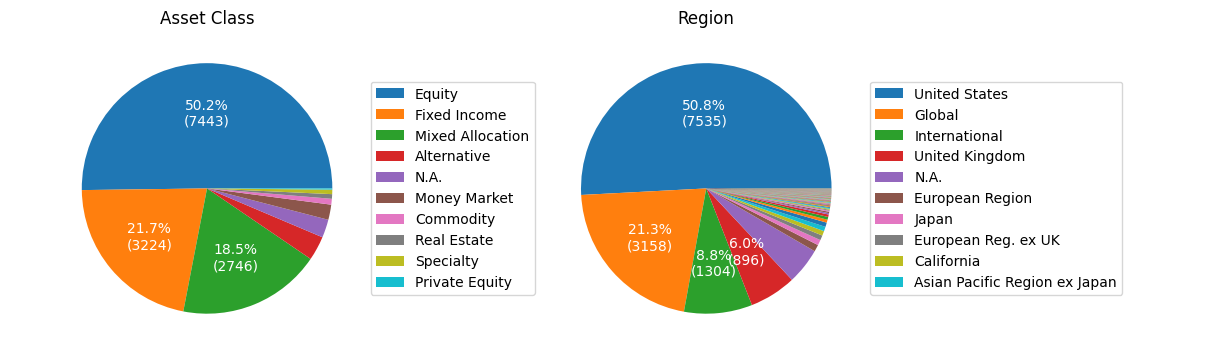

In [5]:
def func(pct, value):
    absolute = int(pct/100.*np.sum(value))
    return "{:.1f}%\n({:d})".format(pct, absolute) if pct > 5 else ""

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
data_col = ["Asset Class", "Region"]

for col, ax in zip(data_col, axs.ravel()):
    data = pool[col].value_counts()
    data.plot(kind="pie", ax=ax, autopct=lambda pct: func(pct, data), textprops=dict(color="w"))
    ax.set_title(col, fontsize=12)
    ax.legend(data.head(10).index, loc="center left", fontsize=10, bbox_to_anchor=(1, 0, 0.5, 1))
    ax.set_ylabel("")

plt.tight_layout()
plt.show()

#fund distribution by asset class & region

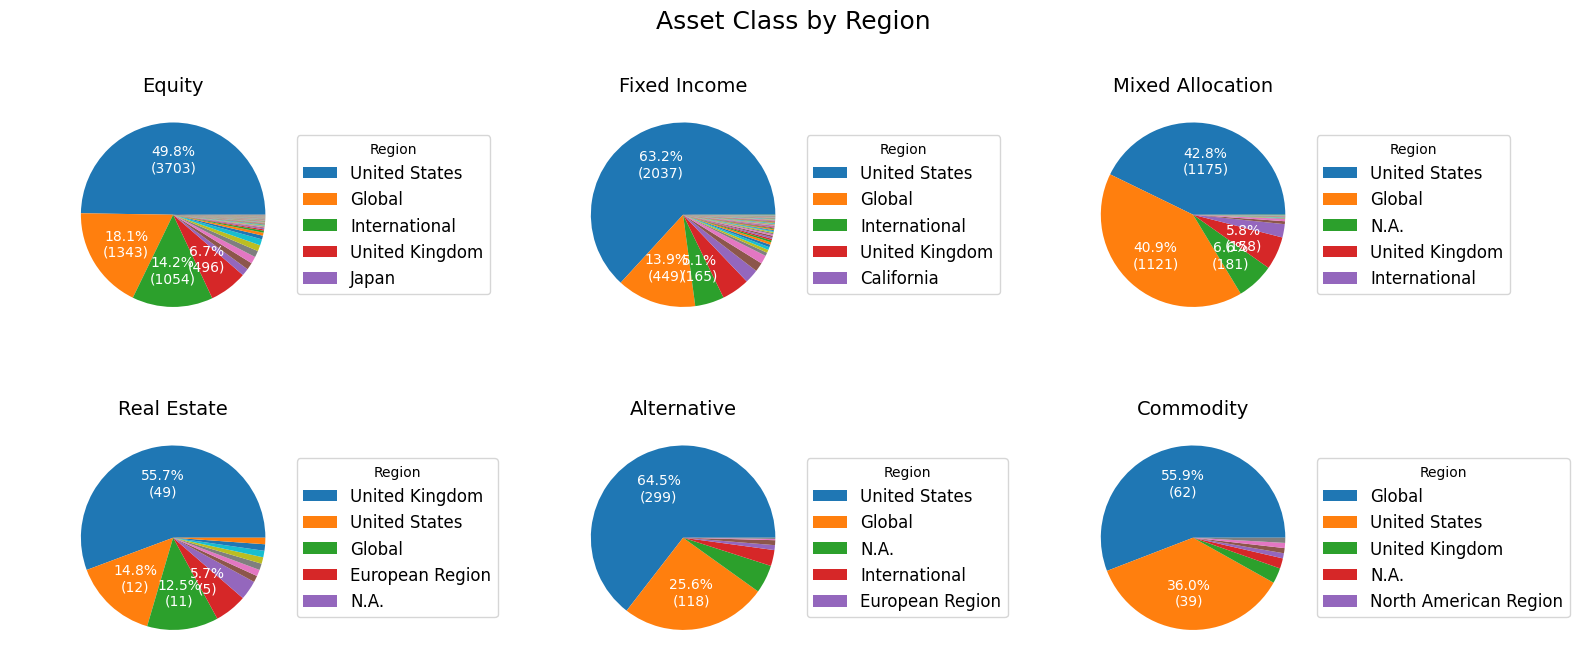

In [6]:
asset_classes = ["Equity", "Fixed Income", "Mixed Allocation", "Real Estate", "Alternative", "Commodity"]

fig, axs = plt.subplots(2, 3, figsize=(15, 7), constrained_layout=True)
fig.suptitle("Asset Class by Region", fontsize=18)
for assets, ax in zip(asset_classes, axs.ravel()):
    data = pool["Region"][pool["Asset Class"] == assets].value_counts()
    data.plot(kind="pie", ax=ax, autopct=lambda pct: func(pct, data), textprops=dict(color="w"))
    ax.set_title(assets,fontsize=14)
    ax.legend(data.head(5).index, title="Region", loc="center left", fontsize=12, bbox_to_anchor=(1, 0, 0.5, 1))
    ax.set_ylabel("")

plt.tight_layout()
plt.show()

#fund distribution by region in each asset class

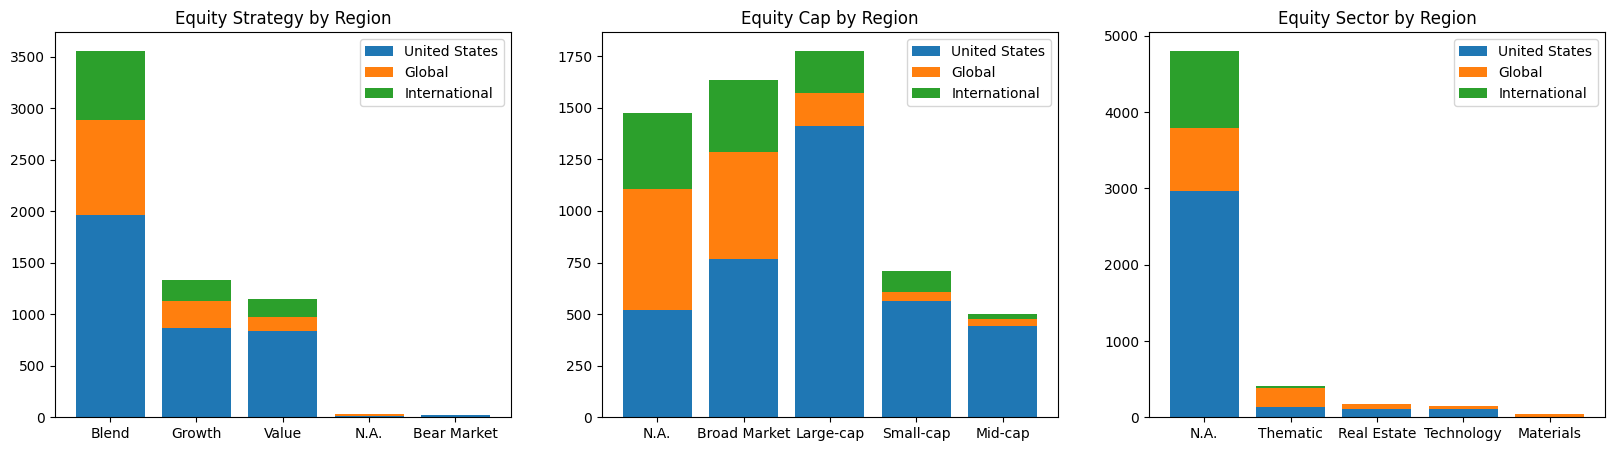

In [7]:
Categories = ['Strategy', 'Cap', 'Sector']
Region = ["United States", "Global", "International"]

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
for ax, category in zip(axes, Categories):
    bottom = None
    for region in Region:
        subset = pool[category][(pool['Asset Class'] == 'Equity') & (pool['Region'] == region)].value_counts().head(5)
        subset = subset.reindex(pool[category][(pool['Asset Class'] == 'Equity') & (pool['Region'] == 'Global')].value_counts().head(5).index, fill_value=0)
        
        ax.bar(subset.index, subset, label=region, bottom=bottom)
        if bottom is None:
            bottom = subset
        else:
            bottom += subset
        
    ax.legend()
    ax.set_title(f'Equity {category} by Region')

plt.show()

#equity fund distribution by strategy/market-cap/sector in each region

In [8]:
for col in pool.columns[3:10]:
    if any(pool[col].str.contains("Emerging Market")):
        print(col,": YES")
    else:
        print(col,"")
        
#separate EM as an individual region

Asset Class 
Region 
Strategy 
Objective : YES
Sector 
Cap 
General Attribute 


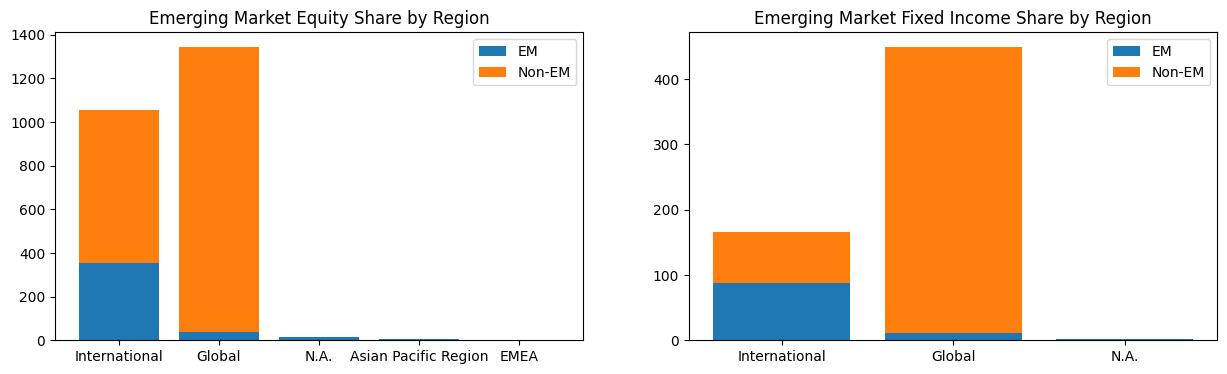

In [9]:
Asset_Class = ['Equity', 'Fixed Income']

fig, axes = plt.subplots(1, 2, figsize=(15, 4))
for ax, asset_class in zip(axes, Asset_Class):
    
    em_data = pool["Region"][(pool["Asset Class"] == asset_class) & (pool["Objective"].str.contains("Emerging Market"))].value_counts().head(5)
    non_em_data = pool["Region"][(pool["Asset Class"] == asset_class) & (~pool["Objective"].str.contains("Emerging Market"))].value_counts().head(5).reindex(em_data.index, fill_value=0)

    ax.bar(em_data.index, em_data)
    ax.bar(non_em_data.index, non_em_data, bottom=em_data)
    ax.legend(["EM", "Non-EM"])
    ax.set_title(f"Emerging Market {asset_class} Share by Region")

plt.show()

#EM funds are mostly in the "International" and "Global" categories

In [10]:
#thematic grouping? pool["Fund"][pool["Sector"] == "Thematic"].value_counts().head(10)

In [11]:
class_strategy = ['Equity','Fixed Income', 'Commodity', 'Alternative','Mixed Allocation', 'Specialty', 'N.A.', 'Real Estate','Private Equity', 'Money Market']

for classes in class_strategy:
    print(classes,"Strategy :\n", pool["Strategy"][pool["Asset Class"]==classes].unique(),"\n")

#identify the strategies in each asset class for fund grouping

Equity Strategy :
 ['Growth' 'Blend' 'Value' 'N.A.' 'Bear Market' 'Dynamic Allocation'
 'Moderate Allocation' 'Global Allocation'] 

Fixed Income Strategy :
 ['Asset Backed' 'Aggregate' 'Corporate' 'Inflation Protected' 'Government'
 'Municipals' 'Bank Loans' 'Mortgage-Backed' 'Convertible' 'Preferred'
 'N.A.'] 

Commodity Strategy :
 ['Precious Metals' 'Energy' 'Broad Based' 'Industrial Metals'
 'Agriculture' 'N.A.'] 

Alternative Strategy :
 ['Equity Hedge' 'Fixed Income Directional' 'Event Driven' 'Macro'
 'CTA/Managed Futures' 'Multi-Strategy' 'N.A.'
 'Fixed Income Relative Value'] 

Mixed Allocation Strategy :
 ['Moderate Allocation' 'Conservative Allocation' 'Aggressive Allocation'
 'Dynamic Allocation' 'Global Allocation' 'Target 2046-2050'
 'Target over 2055' 'Target 2036-2040' 'Target 2026-2030'
 'Target 2031-2035' 'Target 2021-2025' 'Target 2051-2055'
 'Target up to 2015' 'Target 2041-2045' 'Target 2016-2020' 'N.A.' 'Growth'] 

Specialty Strategy :
 ['Specialty' 'Derivative' 

Fund Group
Alternative - Broad Based Commodity          46
Alternative - Digital Currency               24
Alternative - Equity Hedge                  149
Alternative - Event Driven                   31
Alternative - Fixed Income                   58
Alternative - Global Mixed Allocation      1122
Alternative - Macro                          22
Alternative - Managed Futures                35
Alternative - Multi-Strategy                154
Alternative - Other Mixed Allocation        449
Alternative - Others                         77
Alternative - Private Equity                 23
Alternative - Real Estate                    88
Alternative - Single Sector Commodity        65
Alternative - US Mixed Allocation          1175
Equity - EM                                 375
Equity - Global                             794
Equity - International                      670
Equity - Others                            1901
Equity - US Broad                           335
Equity - US Growth           

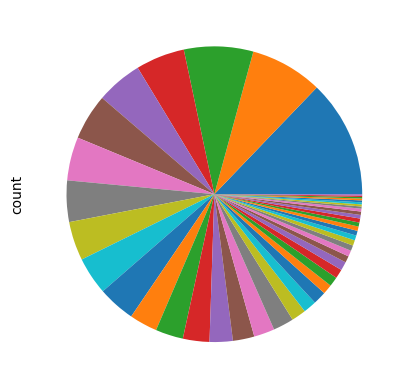

In [12]:
def fund_grouping(row):
  
  #Equity
  if row["Asset Class"] == "Equity" :
    if row["Region"] == "United States":
      if row["Sector"] == "N.A." :
        if   "INCOME"  in row["Fund"] or "DIVID" in row["Fund"]:                                            return "Equity - US Income"
        elif "VOL"     in row["Fund"]:                                                                      return "Equity - US Low-vol"
        elif "QUALITY" in row["Fund"]:                                                                      return "Equity - US Quality"
        elif row["Strategy"] == "Growth":                                                                   return "Equity - US Growth"
        elif row["Strategy"] == "Value":                                                                    return "Equity - US Value"
        elif row["Cap"] == "Large-cap":                                                                     return "Equity - US Large-cap"
        elif row["Cap"] == "Mid-cap":                                                                       return "Equity - US Mid-cap"
        elif row["Cap"] == "Small-cap":                                                                     return "Equity - US Small-cap"
        else:                                                                                               return "Equity - US Broad"
      elif row["Sector"] != "N.A." :
        if   row["Sector"] == "Technology":                                                                 return "Equity - US Tech sector"
        elif row["Sector"] != "Technology":                                                                 return "Equity - US Non-tech sector"
    elif (row["Region"] == "Global" or row["Region"] == "International") and row["Sector"] == "N.A." :
      if "Emerging Market" in row["Objective"] :                                                            return "Equity - EM"
      elif "Emerging Market" not in row["Objective"] :
        if row["Region"] == "Global":                                                                       return "Equity - Global"
        elif row["Region"] == "International":                                                              return "Equity - International"
    else:                                                                                                   return "Equity - Others"

  #Fixed Income
  elif row["Asset Class"] == "Fixed Income" or row["Asset Class"] == "Money Market" :
    if row["Region"] == "United States":
      if  row["Asset Class"] == "Fixed Income":
        if row["Strategy"] == "Aggregate":                                                                  return "Fixed Income - US Aggregate"
        elif row["Strategy"] == "Government":                                                               return "Fixed Income - US Government"
        elif row["Strategy"] == "Corporate":                                                                return "Fixed Income - US Corporate"
        elif row["Strategy"] == "Municipals":                                                               return "Fixed Income - US Municipals"
        elif row["Strategy"] == "Asset Backed":                                                             return "Fixed Income - US ABS"
        elif row["Strategy"] == "Mortgaged-Backed":                                                         return "Fixed Income - US MBS"
        elif row["Strategy"] == "Bank Loans":                                                               return "Fixed Income - US Bank Loans"
        elif row["Strategy"] == "Inflation Protected":                                                      return "Fixed Income - US TIPs"
        elif row["Strategy"] == "Convertible" or row["Strategy"] == "Preferred":                            return "Fixed Income - US Convertible/Preferred"
        else:                                                                                               return "Fixed Income - US Others"
      elif row["Asset Class"] == "Money Market" :                                                           return "Fixed Income - US Money Market"
    elif row["Region"] == "Global" or row["Region"] == "International":
      if   "Emerging Market" in row["Objective"]:                                                           return "Fixed Income - EM"
      elif "Emerging Market" not in row["Objective"]:
        if   row["Region"] == "Global":                                                                     return "Fixed Income - Global"
        elif row["Region"] == "International":                                                              return "Fixed Income - International"
    else:                                                                                                   return "Fixed Income - Others"

  #Alternatives
  elif "BITCOIN" in row["Fund"] or "GRAYSCALE" in row["Fund"] or "CRYPTO" in row["Fund"]:                   return "Alternative - Digital Currency"
  elif row["Asset Class"] == "Alternative":
    if row["Strategy"] == "Multi-Strategy":                                                                 return "Alternative - Multi-Strategy"
    elif row["Strategy"] == "Equity Hedge":                                                                 return "Alternative - Equity Hedge"
    elif row["Strategy"] == "Macro":                                                                        return "Alternative - Macro"
    elif row["Strategy"] == "Event Driven":                                                                 return "Alternative - Event Driven"
    elif row["Strategy"] == "CTA/Managed Futures":                                                          return "Alternative - Managed Futures"
    elif row["Strategy"] == "Fixed Income Directional" or row["Strategy"] == "Fixed Income Relative Value": return "Alternative - Fixed Income"
    else:                                                                                                   return "Alternative - Others"
  elif row["Asset Class"] == "Specialty":                                                                   return "Alternative - Others"
  elif row["Asset Class"] == "Private Equity":                                                              return "Alternative - Private Equity"
  elif row["Asset Class"] == "Commodity":
    if   row["Strategy"] == "Broad Based" or row["Strategy"] == "N.A.":                                     return "Alternative - Broad Based Commodity"
    else:                                                                                                   return "Alternative - Single Sector Commodity"
  elif row["Asset Class"] == "Real Estate":                                                                 return "Alternative - Real Estate"
  elif row["Asset Class"] == "Mixed Allocation":
    if   row["Region"] == "United States":                                                                  return "Alternative - US Mixed Allocation"
    elif row["Region"] == "Global":                                                                         return "Alternative - Global Mixed Allocation"
    else:                                                                                                   return "Alternative - Other Mixed Allocation"

  else:
    return "Others"

pool["Fund Group"] = pool.apply(fund_grouping,axis=1)
print(pool["Fund Group"].value_counts().sort_index())
pool["Fund Group"].value_counts().plot.pie(legend=False, labels=None)
plt.show()

#fund grouping

In [13]:
return_missing = (
    ( (pool["10YR"].isnull()) & (pool["5YR"].isnull()) & (pool["3YR"].isnull()) & (pool["1YR"].isnull()) ) |            # 1Y(X) 3Y(X) 5Y(X) 10Y(X)
    ( (pool["10YR"].notnull()) & ( (pool["5YR"].isnull()) | (pool["3YR"].isnull()) | (pool["1YR"].isnull()) ) ) |       # 1Y(X) 3Y(X) 5Y(X) 10Y(O)
    ( (pool["10YR"].notnull()) & ((pool["5YR"].notnull())) & ( (pool["3YR"].isnull()) | (pool["1YR"].isnull()) ) ) |    # 1Y(X) 3Y(X) 5Y(O) 10Y(O)
    ( (pool["10YR"].notnull()) & (pool["5YR"].notnull()) & (pool["3YR"].notnull()) & (pool["1YR"].isnull()) ) |         # 1Y(X) 3Y(O) 5Y(O) 10Y(O)
    ( (pool["10YR"].isnull()) & (pool["5YR"].notnull()) & ( (pool["3YR"].isnull()) | (pool["1YR"].isnull()) ) ) |       # 1Y(X) 3Y(X) 5Y(O) 10Y(X)
    ( (pool["10YR"].isnull()) & (pool["5YR"].isnull()) & (pool["3YR"].notnull()) & (pool["1YR"].isnull()) )             # 1Y(X) 3Y(O) 5Y(X) 10Y(X)
 )
return_fine = (~return_missing)

sharpe_missing = ( ( ( pool["10YR"].notnull() ) | ( pool["5YR"].notnull() ) ) & ( pool["Sharpe"].isnull() ) )
sharpe_negative = ((~ sharpe_missing) & (pool["Sharpe"] < 0))
sharpe_fine = ( ( (~ sharpe_missing) & (pool["Sharpe"] >= 0) ) | ( (pool["10YR"].isnull()) & (pool["5YR"].isnull()) & (pool["Sharpe"].isnull()) ) )

aum_missing = (pool["AUM"].isnull())
aum_negative = ((pool["AUM"].notnull()) & (pool["AUM"] < 100))
aum_fine = ((pool["AUM"].notnull()) & (pool["AUM"] > 100))

conditions = [
    (aum_missing) & (return_missing) & (sharpe_missing),
    (aum_missing) & (return_missing) & (sharpe_negative),
    (aum_missing) & (return_missing) & (sharpe_fine),
    (aum_missing) & (return_fine) & (sharpe_missing),
    (aum_missing) & (return_fine) & (sharpe_negative),
    (aum_missing) & (return_fine) & (sharpe_fine),

    (aum_negative) & (return_missing) & (sharpe_missing),
    (aum_negative) & (return_missing) & (sharpe_negative),
    (aum_negative) & (return_missing) & (sharpe_fine),
    (aum_negative) & (return_fine) & (sharpe_missing),
    (aum_negative) & (return_fine) & (sharpe_negative),
    (aum_negative) & (return_fine) & (sharpe_fine),

    (aum_fine) & (return_missing) & (sharpe_missing),
    (aum_fine) & (return_missing) & (sharpe_negative),
    (aum_fine) & (return_fine) & (sharpe_missing),
    (aum_fine) & (return_fine) & (sharpe_negative),
    (aum_fine) & (return_missing) & (sharpe_fine)
]

choices = [
    "AUM/Return/Sharpe missing",
    "AUM/Return missing, Sharpe < 0",
    "AUM/Return missing",
    "AUM/Sharpe missing",
    "AUM missing, Sharpe < 0",
    "AUM missing",

    "AUM < $100M, Return/Sharpe missing",
    "AUM < $100M, Return missing, Sharpe < 0",
    "AUM < $100M, Return missing",
    "AUM < $100M, Sharpe missing",
    "AUM < $100M, Sharpe < 0",
    "AUM < $100M",

    "Return/Sharpe missing",
    "Return missing, Sharpe < 0",
    "Sharpe missing",
    "Sharpe < 0",
    "Return missing"
]

pool["Fund Warnings"] = np.select(conditions,choices,"")
pool["Fund Warnings"].value_counts()

#note the potential issues for each fund

Fund Warnings
                                      7383
AUM < $100M                           3557
Sharpe < 0                            1272
AUM < $100M, Sharpe < 0                530
AUM < $100M, Return missing            482
AUM < $100M, Sharpe missing            342
Sharpe missing                         312
AUM missing                            283
AUM/Return missing                     203
Return missing                         140
AUM < $100M, Return/Sharpe missing     138
Return/Sharpe missing                   94
AUM/Sharpe missing                      40
AUM missing, Sharpe < 0                 35
AUM/Return/Sharpe missing               12
Name: count, dtype: int64

In [14]:
pool["Index Fund"] = pool["General Attribute"].apply(lambda x: "YES" if "Index" in x else "")

In [15]:
def fund_elimination(row):
  if row["AUM"] < 30:
    return "X (AUM < $30M)"
  else:
    if (pd.isnull(row["10YR"])) and (pd.isnull(row["5YR"])) and (pd.isnull(row["3YR"])) and (pd.isnull(row["1YR"])):
      return "X (Return unavailable)"
    else:
      if (pd.isnull(row["10YR"])) and (pd.isnull(row["5YR"])) and ( (pd.notnull(row["3YR"])) or (pd.notnull(row["1YR"])) ):
        return "X (Inception < 5y)"
      else:
        if (row["10YR"] > 100) or (row["5YR"] > 100) or (row["3YR"] > 100) or (row["1YR"] > 100):
          return "X (Return incorrect)"
        else: return ""

pool["Fund Elimination"] = pool.apply(fund_elimination, axis=1)
pool["Fund Elimination"].value_counts()

#eliminate the funds based on certain criteria

Fund Elimination
                          9717
X (AUM < $30M)            2680
X (Inception < 5y)        1931
X (Return unavailable)     464
X (Return incorrect)        31
Name: count, dtype: int64

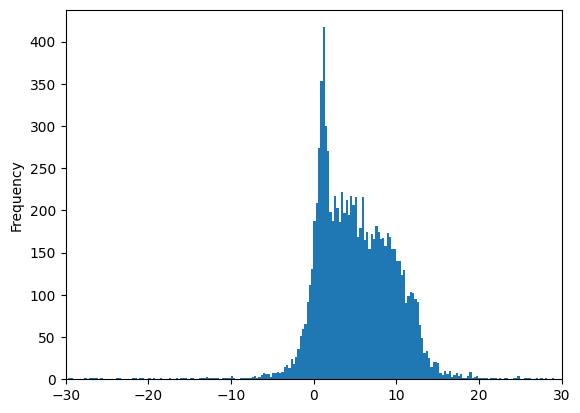

In [16]:
def wavg_return(row): #weighted average return: combing the annualized returns of different horizons
  if row["Fund Elimination"]=="":
    if   (pd.notnull(row["10YR"])) and (pd.notnull(row["5YR"])) and (pd.notnull(row["3YR"])):   return 0.5 * row["10YR"] + 0.3 * row["5YR"] + 0.2 * row["3YR"]
    elif (pd.isnull(row["10YR"])) and (pd.notnull(row["5YR"])) and (pd.notnull(row["3YR"])):    return 0.6 * row["5YR"] + 0.4 * row["3YR"]
    elif (pd.notnull(row["10YR"])) and (pd.isnull(row["5YR"])) and (pd.notnull(row["3YR"])):    return 0.7 * row["10YR"] + 0.3 * row["3YR"]
    elif (pd.notnull(row["10YR"])) and (pd.isnull(row["5YR"])) and (pd.isnull(row["3YR"])):     return row["10YR"]
    else: return "error"
  else:
    return ""

pool["Fund WAVG Return"] = pool.apply(wavg_return,axis=1)
pool['Fund WAVG Return'] = pd.to_numeric(pool['Fund WAVG Return'], errors='coerce')
pool['Fund WAVG Return'].plot(kind="hist", bins=500, xlim=(-30, 30))

pool['WAVG Return Decile'] = pool.groupby('Fund Group')['Fund WAVG Return'].transform(lambda x: pd.qcut(x, q=10, labels=False, duplicates='drop'))
pool['WAVG Return Decile'] = pool['WAVG Return Decile'].apply(lambda x: f'Top {100 - int((x) * 10)}%' if pd.notna(x) else 'NaN')

#calulate the weighted average return and rank decile of each fund

In [17]:
pool.insert(3, 'Fund Group', pool.pop('Fund Group'))
pool.insert(4, 'Fund WAVG Return', pool.pop('Fund WAVG Return'))
pool.insert(5, 'WAVG Return Decile', pool.pop('WAVG Return Decile'))
pool.insert(6, 'Fund Elimination', pool.pop('Fund Elimination'))
pool.insert(7, 'Fund Warnings', pool.pop('Fund Warnings'))
pool.insert(8, 'Index Fund', pool.pop('Index Fund'))
pool = pool.sort_values(by=["Fund Group","Fund WAVG Return"],ascending=[True,False])
pd.set_option('display.max_columns', None)
pool

#full fund list

,#,Ticker,Fund,Fund Group,Fund WAVG Return,WAVG Return Decile,Fund Elimination,Fund Warnings,Index Fund,Asset Class,Region,Strategy,Objective,Sector,Cap,General Attribute,Fund Type,1YR,3YR,5YR,10YR,AUM,Sharpe,Dividend Yield,Fee
154,155,BCD US Equity,ABRDN BLOOMBERG ALL COMMODIT,Alternative - Broad Based Commodity,14.10,Top 10%,,,,Commodity,Global,Broad Based,Broad Based,N.A.,N.A.,N.A.,Exchange-Traded Fund,-2.9,21.0,9.5,NaN,260.0,0.5,5.5,0.29
1991,1992,PDBC US Equity,INVESCO OPTIMUM YIELD DIVERS,Alternative - Broad Based Commodity,13.98,Top 10%,,,,Commodity,United States,Broad Based,Broad Based,N.A.,N.A.,N.A.,Exchange-Traded Fund,-6.7,23.4,7.7,NaN,5023.0,0.3,13.5,0.64
1038,1039,FTGC US Equity,FIRST TRUST GLOBAL TACTICAL,Alternative - Broad Based Commodity,13.30,Top 10%,,,,Commodity,United States,Broad Based,Broad Based,N.A.,N.A.,N.A.,Exchange-Traded Fund,1.3,21.4,7.9,NaN,2613.0,0.4,12.1,0.95
400,401,COM US Equity,DIREXION AUSPICE BRD CMDTY,Alternative - Broad Based Commodity,12.84,Top 10%,,,,Commodity,Global,Broad Based,Broad Based,N.A.,N.A.,N.A.,Exchange-Traded Fund,2.5,18.9,8.8,NaN,302.0,0.7,4.7,0.72
8522,8523,PQCMX US Equity,PGIM QMA SOL CMDY STRT F-R6,Alternative - Broad Based Commodity,11.98,Top 20%,,AUM < $100M,,Commodity,United States,Broad Based,Broad Based,N.A.,N.A.,N.A.,Open-Ended Fund,-9.0,19.3,7.1,NaN,62.0,0.3,33.3,0.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14071,14072,HCQCRGA LN Equity,WS QUAYS CONSERV-ACC GBX,Others,NaN,NaN,X (AUM < $30M),AUM < $100M,,N.A.,N.A.,N.A.,N.A.,N.A.,N.A.,N.A.,Fund of Fund,-6.9,NaN,NaN,NaN,10.0,NaN,0.0,NaN
14198,14199,KAMDACG LN Equity,AON MANAGED GLB IM-ACC GBP,Others,NaN,NaN,X (Inception < 5y),AUM missing,,N.A.,N.A.,N.A.,N.A.,N.A.,N.A.,N.A.,Fund of Fund,11.3,NaN,NaN,NaN,NaN,NaN,0.0,NaN
14276,14277,MGIFWAA LN Equity,MGTS FUTURE WEALTH-A ACC,Others,NaN,NaN,X (AUM < $30M),AUM < $100M,,N.A.,N.A.,N.A.,N.A.,N.A.,N.A.,N.A.,Fund of Fund,-2.2,NaN,NaN,NaN,0.0,NaN,0.0,NaN
14390,14391,OGBPLKM LN Equity,AON MANAGED UK LG-OGBP,Others,NaN,NaN,X (Inception < 5y),AUM missing,,N.A.,N.A.,N.A.,N.A.,N.A.,N.A.,N.A.,Fund of Fund,-69.6,-33.7,NaN,NaN,NaN,NaN,0.0,NaN


In [18]:
columns_to_drop = ['#', 'Asset Class', 'Region', 'Strategy', 'Objective', 'Sector', 'Cap','General Attribute']
pool_lite = pool.drop(columns=columns_to_drop)

fund_group_dropdown = widgets.Dropdown(options=pool_lite["Fund Group"].unique(), description='Fund Group:')
column_sort_dropdown = widgets.Dropdown(options=pool_lite.columns, value="Fund WAVG Return", description='Sort by:')
num_rows_input = widgets.IntText(value=10, description='# of Rows:')
filter_column_dropdown = widgets.Dropdown(options=pool_lite.columns, value='AUM', description='Filter:')
filter_threshold_input = widgets.IntText(value=0, description='Filter Input:')

def get_data(fund_group, sort_column, num_rows, filter_column, filter_threshold):
    filtered_df = pool_lite[pool_lite["Fund Group"] == fund_group].copy()
    filtered_df.sort_values(by=sort_column, ascending=False, inplace=True)
    filtered_df = filtered_df[filtered_df[filter_column] > filter_threshold]
    #pd.set_option('display.max_columns', None)
    return filtered_df.head(num_rows)

result_df = interact(get_data, fund_group=fund_group_dropdown, sort_column=column_sort_dropdown, num_rows=num_rows_input, filter_column=filter_column_dropdown, filter_threshold=filter_threshold_input)

#subset the top funds in each fund group ranked by returns with optional filter and number of funds to include

interactive(children=(Dropdown(description='Fund Group:', options=('Alternative - Broad Based Commodity', 'Alt…

In [19]:
#result_df.widget.result => extract the selected dataset for further manipulation